# Homework 4: Let's simulate a microscope
Due: Apr 6, 2023 at 11:00 pm

Submit through Gradescope. Please upload .ipynb

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

The goal of this homework assignment is to create a physically accurate simulation of an optical microscope. This should give you an idea of how to treat an imaging system as a linear system, by performing filtering in the Fourier domain. This type of model is also applicable to imaging with other EM radiation, ultrasound, MRI, CT etc.

This simulation will: 

1. Illuminate a thin sample (with finite thickness variations) with light from a particular angle.
2. The emerging light will then propagate from the sample to the microscope lens,
3. The light will be filtered by the microscope lens,
4. Finally, the light will propagate to the image sensor where it will be detected.

Because things are small within a microscope, you have to treat light as a wave. So, we'll be defining the sample, illumination and lens effects as complex-valued vectors.

As a first step, you should define all of the variables of interest and an (x,y) coordinate system for the sample. The variables will include the size of the sample. Here will we use a sample size of $d_{sample}=0.25 mm$, which is a typical size for a microscope sample. To model the object in the computer, we will need to form a discretized representation of the sample. Thanks to the sampling theorem, that is easily doable. 
But what is a reasonable sampling to model the microscope?
The resolution of a microscope (r) is usually defined as:

$r = 0.61\lambda/NA$

with $\lambda$ as wavelength and the numerical aperture (NA) of the imaging system. For most microscopes the NA ranges between 0.1 and 1.3. And NA>1 typically require water or oil immesion. See https://www.microscopyu.com/microscopy-basics/resolution for a nice table.

According to that, the smalltest feature that a really good microscope (NA=1.22) can resolve is around half the wavelength of light. Thus, it is a good rule-of-thumb to use half the wavelength as sampling criterion ($\Delta x = 0.5\lambda$) for discretizing the sample in our model. 

Let's assume the wavelength of light that we'll use is $\lambda$=0.5 $\mu$m (which is greenish light). We can then select the number of discrete elements to split the sample up into as $n_{elem}$ elements:

$n_{elem}=d_{sample}/\Delta x = 250\mu m/0.25\mu m = 1000$

You can use the np.linspace function to create x and y axes, and the np.meshgrid function to generate a 2D array of x and y values that will be useful later.

In [2]:
wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
size_sample = 0.25
num_samples = int(size_sample/delta_x) # num_samples needs to be an integer

# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid coordinates as needed
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx, yy = np.meshgrid(x, y)

Next, load an image to use as the test sample. We have included a test target image that is usually used to check the resolution of the microscope. In addition to simulating a sample with this image, please feel free to also use another image of your choice to create a different simulated sample. 

For the assignment, please use the test target image to simulate two different types of samples: one that has both absorption and phase delay (as in the code below), and then later for question (c), one that is only absorptive.

The sample_phase definition deserves a bit of explanation. As explained in class, the phase represents the optical pathlength of the specimen, which is a function of refractive index and thickness. Since it is not easy to find datasets of aborption and optical thickness, here we'll just use an image that represents absorption, and then make an approximation to estimate its optical pathlength. We will assume that the sample's optical pathlength is directly proportional to the absorption (hope it is clear from the equation why that is the case!)  

In [3]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
img = Image.open(BytesIO(response.content))
sample = np.array(img)

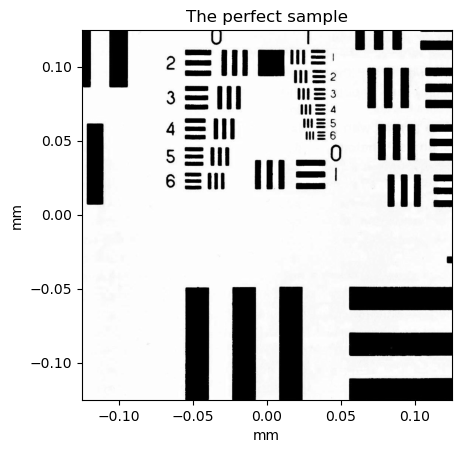

In [4]:
# Define sample absorption
sample = sample/sample.max()
# sample_amplitude = sample/sample.max()
# Add in sample phase delay  - assume sample thickness linearly proportional to absorption
sample_phase = 1 - sample
optical_pathlength = 20 * wavelength
sample = sample * np.exp(1j * sample_phase*optical_pathlength/wavelength) #complex exponential represents phase delay

# show absolute value of sample = its absorption
plt.figure()
plt.imshow(np.abs(sample), extent=(x[0], x[-1], y[0], y[-1]))
plt.title('The perfect sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

Next, let's model a plane wave hitting this thin sample. I've written down the general form of a plane wave for you guys below. Note that you can simulate the plane wave hit the sample at a desired angle ($\theta_x$,$\theta_y$).

In [5]:
# Define plane wave
plane_wave_angle_x = 0 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

Text(0.5, 1.0, 'The emerging field of the sample')

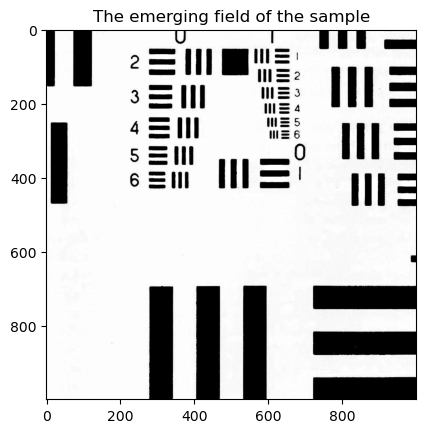

In [6]:
plt.imshow(np.abs(emerging_field))
plt.title('The emerging field of the sample')

Now, let's propagate this field to the lens aperture plane via a Fourier transform, to create the sample spectrum. It is also helpful to define a set of coordinates $(f_x,f_y)$ at this Fourier transform plane. You can use the $(x,y)$ coordinates that you formed above, as well as the relationship $2f_x^{max}=1/\Delta x$, to define the $(f_x,f_y)$ coordinates. That is, the full range of the spatial frequency axis is inversely proportional to the smallest step size in the spatial axis, that we defined at the beginning. Please go ahead and plot the magnitude of the sample spectrum with a set of marked and labeled axes (like for the sample in space). It is helpful to plot it on a log scale for visualization.

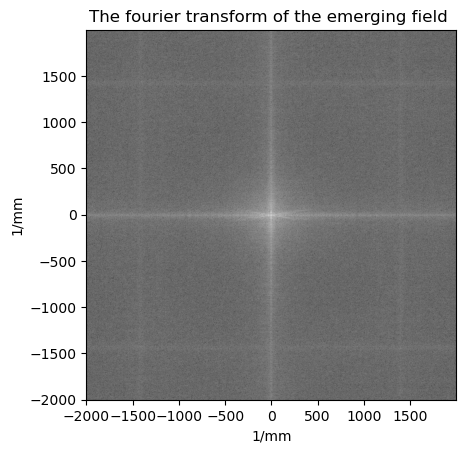

In [7]:
# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  1000
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Take 2D fourier transform of sample
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transform of the emerging field ')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

Next, define the lens transfer function as a circle with a finite radius in the spatial frequency domain. Inside the circle the value of the transfer function is 1, and outside it is 0. Let's make the lens transfer function diameter 1/4-th the total spatial frequency axis coordinates. Please take a moment to understand what this means with respect to the real numerical aperture of this particular lens. Remember that the frequency range was defined based on $NA=1.22$, as discussed in the beginning. Can you estimate the NA of this imaging sytsem? 

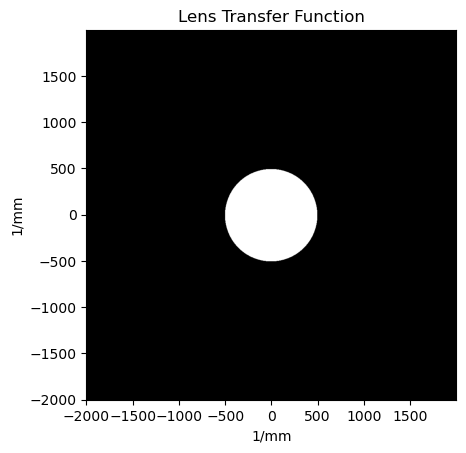

In [8]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d =int((ending_coordinate - starting_coordinate+1) / 4)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

You can now filter the sample spectrum with the lens transfer function, propagate this filtered spectrum to the image plane, and sample it on a detector that only detects the intensity of light, as we've shown in class. Let's assume the magnification of the lens is 5X (meaning the image of the sample at the detector plane is 5X larger than it is at the lens plane). Please display the resulting image on a new coordinate system, $(x',y')$ which represent the coordinates at the detector plane.

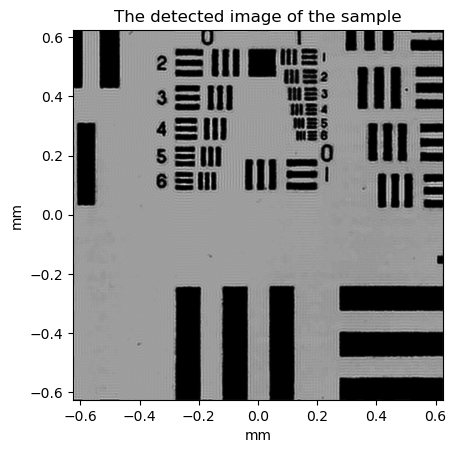

In [9]:
# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected image of the sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

Great! You've simulated a microscope image!  Now let's try to change a few parameters to see what happens. Please try out the following tests and briefly answer the following questions:

(a) Let's try changing the illumination angle by 5 degrees in x coordinate. What happens to the sample spectrum at the aperture plane? Why does that change the appearance of the image? 

(b) Try again with a larger angle of illumination that changes the appearance of the image more dramatically, until the background of the image becomes black. This is called a "dark-field" image. Why is there a transition from an image with a bright background to a dark background, and under what illumination angle conditions does this occur?

(c) Let's change the lens numerical aperture with 0 angles of illumination. Instead of a circle having a diameter that is 25% the width of the frequency domain, let's try a smaller lens with a lens diameter that is 10% of the width of the frequency domain. How does the appearance of the image change? And why?

(d) Next, let's try a wider lens with 50% width. Describe how the appearance of the image changes and why. 

(e) The lens aperture does not have to be a circle - it can be whatever shape you want. Go ahead and add an "apodizer" into the lens, which is (literally) a black circle marked onto the center of the lens. You can model this dark circle by making the center of the lens aperture circle zero, up to some first radius, then the lens aperture is 1 up to some second radius, and then the lens aperture ends and everything is zero again (this will form a ring). How does the appearance of the resulting image change, and why? Still do not change the angle of illumination.

# (a) Let's try changing the illumination angle by 5 degrees in x coordinate. What happens to sample spectrum at the aperture plane? Why does that change the appearance of the image? - 10 points

In [10]:
# First load up the image
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
img = Image.open(BytesIO(response.content))
sample = np.array(img)

wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
num_samples = 1000

# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid coordinates as needed
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx, yy = np.meshgrid(x, y)

# Define sample absorption
sample = sample/sample.max()

# Add in sample phase delay  - assume sample thickness linearly proportional to absorption
sample_phase = 1 - sample
optical_pathlength = 20 * wavelength
sample = sample * np.exp(1j * sample_phase*optical_pathlength/wavelength) #complex exponential represents phase delay

In [11]:
# Change incident angle 5 degrees in x direction
# Define plane wave
plane_wave_angle_x = 5 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

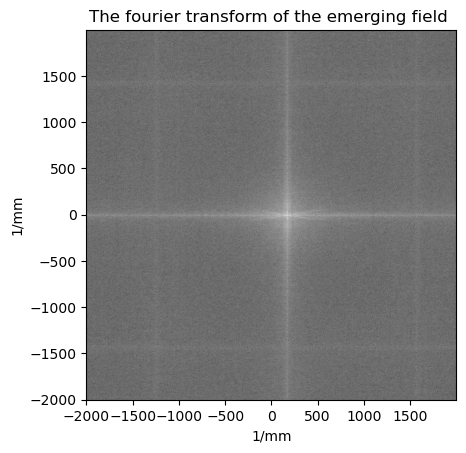

In [12]:
# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  1000
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Take 2D fourier transform of sample
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transform of the emerging field ')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

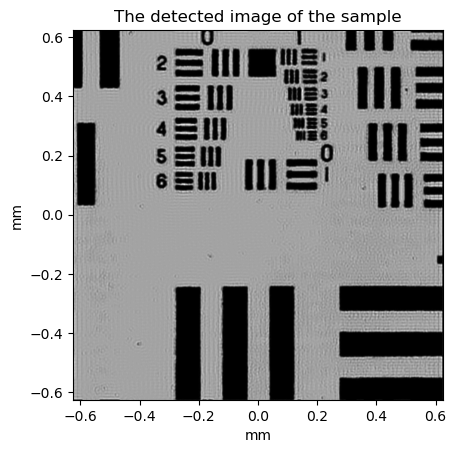

In [13]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d =int((ending_coordinate - starting_coordinate+1) / 4)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected image of the sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

By changing the illumination angle by 5 degrees in the x-coordinate, we observe a shift in the sample spectrum at the aperture plane in the x direction.

Though we see negligible change in the appearance of the detected image, it happens because the lens acts as a filter in the fourier domain. As we change the illumination angle, the sample spectrum changes in the fourier domain. The lens filter is applied to the sample spectrum and therefore the appearance of the detected image changes.

# (b) Try again with a larger angle of illumination that changes the appearance of the image dramatically, such that the background of the image becomes black. This is called a "dark-field" image. Why is there a transition from an image with a bright background to a dark background, and under what illumination angle conditions does this occur? - 10 points

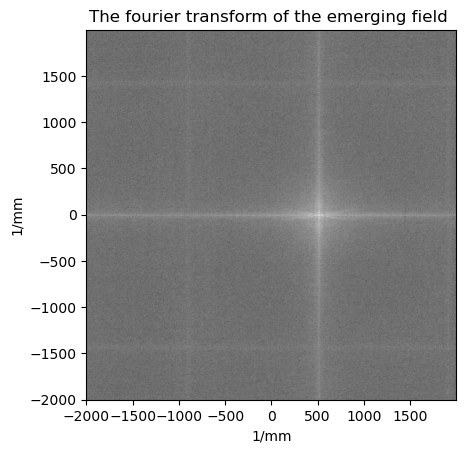

In [14]:
# Change incident angle different angles in x direction to see what angle gives dark background
# Define plane wave
plane_wave_angle_x = 15 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  1000
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

# Take 2D fourier transform of sample
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transform of the emerging field ')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

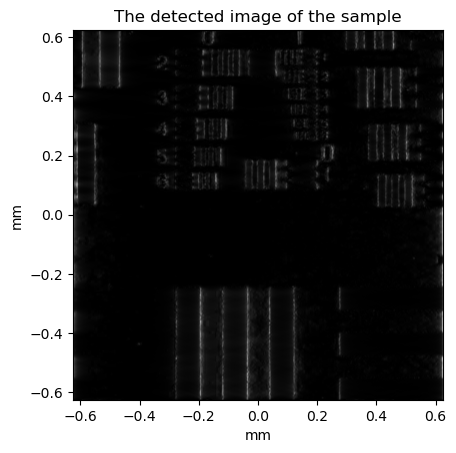

In [15]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d =int((ending_coordinate - starting_coordinate+1) / 4)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected image of the sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

After increasing the angle of illumination to 15 degrees, we observe that the background of the image becomes black.

The transition from an image with bright background to one with a dark background takes place because as we use a larger angle of illumination, it causes the light to scatter at higher angles. This causes very little to no light directly entering the lens. Hence, the background of the image becomes black.

# (c) Let's change the lens numerical aperture and keep the illumination angle at 0°. Instead of an spherical aperature having a diameter that is 25% the width of the frequency domain, let's try a smaller lens with a lens diameter that is 10% of the width of the frequency domain. How does the appearance of the image change? And why? - 10 points

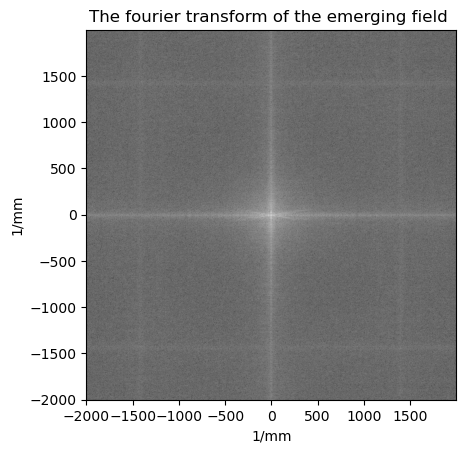

In [16]:
# Define plane wave
plane_wave_angle_x = 0 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  1000
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

# Take 2D fourier transform of sample
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transform of the emerging field ')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

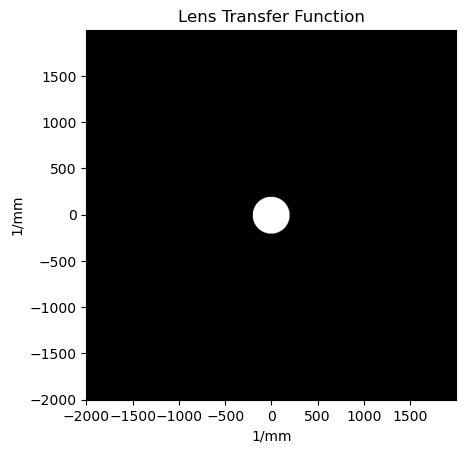

In [17]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d =int((ending_coordinate - starting_coordinate+1) / 10)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

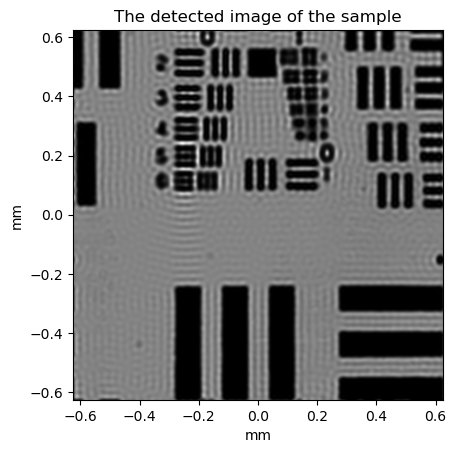

In [18]:
# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected image of the sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

After using a smaller lens with diameter of 10% of width of the frequency domain, we observe that the background of the image becomes darker and the resolution of the image decreases.

This is because a lens with a smaller aperture corresponds to a lower numerical aperture, which limits the maximum angle at which light can enter the lens. This reduces the spatial frequency content passing through and hence, the background of the image becomes darker and the resolution of the image decreases.

# (d) Next, let's try a wider lens with 50%. Describe how the appearance of the image changes and why.  - 10 points

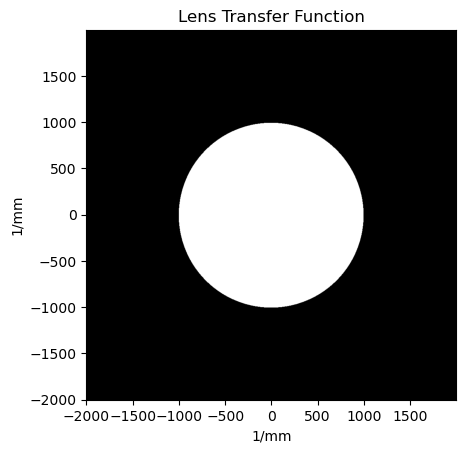

In [19]:
# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d =int((ending_coordinate - starting_coordinate+1) / 2)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

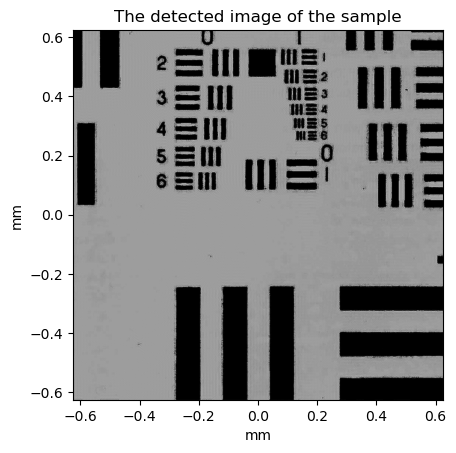

In [20]:
# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected image of the sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

After using a wider lens with diameter of 50% of width of the frequency domain, we observe that the background of the image becomes brighter and the resolution of the image increases.

This is because a lens with a larger aperture corresponds increases the spatial frequency content passing through the lens.

# (e) The lens aperture does not have to be a circle - it can be whatever shape you want. Go ahead and add an "apodizer" into the lens, which is (literally) a black circle marked onto the center of the lens. You can model this dark circle by making the center of the lens aperture circle zero, up to some first radius, then the lens aperture is 1 up to some second radius, and then the lens aperture ends and everything is zero again (this will form a ring). How does the appearance of the resulting image change, and why? Still do not change the angle of illumination. - 10 points

In [21]:
wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
num_samples = 1000

from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
img = Image.open(BytesIO(response.content))
sample = np.array(img)

# Define sample absorption
sample = sample/sample.max()

# Add in sample phase delay  - assume sample thickness linearly proportional to absorption
sample_phase = 1 - sample
optical_pathlength = 20 * wavelength
sample = sample * np.exp(1j * sample_phase*optical_pathlength/wavelength) #complex exponential represents phase delay

# Define plane wave
plane_wave_angle_x = 0 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  1000
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Take 2D fourier transform of sample
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

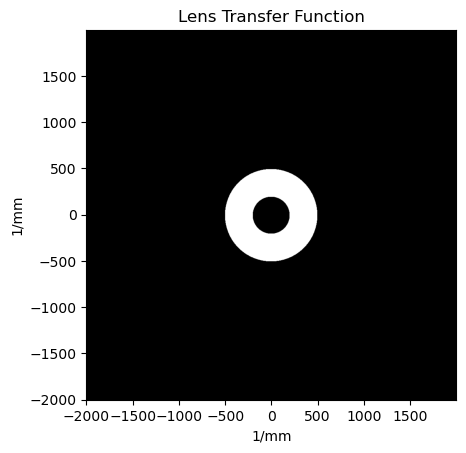

In [22]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d_1 =int((ending_coordinate - starting_coordinate+1) / 10)
d_2 =int((ending_coordinate - starting_coordinate+1) / 4)
r_1 = d_1/2
r_2 = d_2/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where((dist<r_2) & (dist>r_1))]=1

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

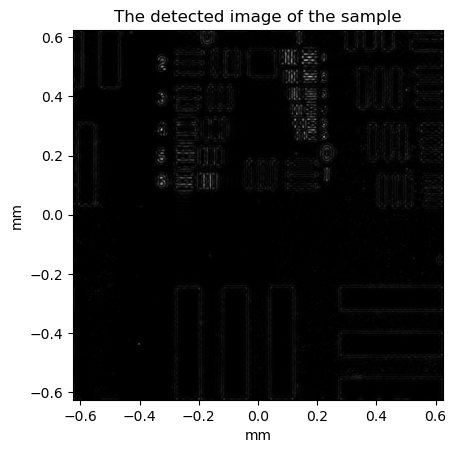

In [23]:
# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected image of the sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

After adding an apodizer to the lens, we observe an image with a black background.

Adding the apodizer blocks off the center portion of the lens which reduces the amount of spatial frequency that can pass through the lens. As a result, the background becomes black and the resolution of the image decreases.